In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers


     |████████████████████████████████| 2.6 MB 35.9 MB/s 
     |████████████████████████████████| 895 kB 48.9 MB/s 
     |████████████████████████████████| 3.3 MB 57.6 MB/s 
     |████████████████████████████████| 636 kB 40.5 MB/s 


In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 4.9.0



In [5]:

#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
!unzip /content/drive/MyDrive/datasets.zip


Archive:  /content/drive/MyDrive/datasets.zip
   creating: datasets/
  inflating: datasets/classifiedExtremismAnsar.txt  
  inflating: datasets/classifiedExtremismTurnToIslam.txt  
  inflating: datasets/classifiedMovies.txt  
  inflating: datasets/classifiedSentiment140_Test.txt  
  inflating: datasets/classifiedSentiment140_Training.txt  
  inflating: datasets/classifiedT4SA.txt  
  inflating: datasets/._readme.txt   
  inflating: datasets/readme.txt     
  inflating: __MACOSX/datasets/._readme.txt  


In [8]:
ls datasets/


classifiedSentiment140_Test.txt*      readme.txt*
classifiedSentiment140_Training.txt*


In [9]:
df_sent140_tr = pd.read_csv('/content/datasets/classifiedSentiment140_Training.txt', sep="\t", header= None,  engine='python')

In [10]:
df_sent140_tst = pd.read_csv('/content/datasets/classifiedSentiment140_Test.txt', sep="\t", header= None,  engine='python')

In [11]:
df_sent140_tr.columns = ["id","message","scoreP","scoreN","polarity","originalClassification","termsP","termsN"]
df_sent140_tst.columns = ["id","message","scoreP","scoreN","polarity","originalClassification","termsP","termsN"]

In [12]:
df = df_sent140_tr
df1 = df_sent140_tst


In [13]:
df

,id,message,scoreP,scoreN,polarity,originalClassification,termsP,termsN
0,1467810672,"b""is upset that he can't update his Facebook b...",0.00,0.0,Inconclusive,0,NaN,NaN
1,1467810917,b'@Kenichan I dived many times for the ball. M...,0.00,0.0,Inconclusive,0,NaN,NaN
2,1467811184,b'my whole body feels itchy and like its on fi...,0.00,0.0,Inconclusive,0,NaN,NaN
3,1467811193,"b""@nationwideclass no, it's not behaving at al...",0.00,0.0,Inconclusive,0,NaN,NaN
4,1467811372,b'@Kwesidei not the whole crew ',0.00,0.0,Inconclusive,0,NaN,NaN
...,...,...,...,...,...,...,...,...
3199993,2193601966,b'Just woke up. Having no school is the best f...,0.00,0.0,Inconclusive,4,NaN,NaN
3199994,2193601969,b'TheWDB.com - Very cool to hear old Walt inte...,0.00,0.0,Inconclusive,4,NaN,NaN
3199995,2193601991,b'Are you ready for your MoJo Makeover? Ask me...,0.00,0.0,Inconclusive,4,NaN,NaN
3199996,2193602064,b'Happy 38th Birthday to my boo of alll time!!...,0.89,0.0,Positive Extreme,4,happy,NaN


In [14]:
df1

,id,message,scoreP,scoreN,polarity,originalClassification,termsP,termsN
0,4,b'Reading my kindle2... Love it... Lee childs...,0.00,0.0,Inconclusive,4,NaN,NaN
1,5,"b'Ok, first assesment of the #kindle2 ...it fu...",0.00,0.0,Inconclusive,4,NaN,NaN
2,6,"b""@kenburbary You'll love your Kindle2. I've h...",0.00,0.0,Inconclusive,4,NaN,NaN
3,7,"b""@mikefish Fair enough. But i have the Kindl...",0.87,0.0,Positive Extreme,4,perfect,NaN
4,8,"b""@richardebaker no. it is too big. I'm quite ...",0.89,0.0,Positive Extreme,4,happy,NaN
...,...,...,...,...,...,...,...,...
1983,14072,b'Ask Programming: LaTeX or InDesign?: submitt...,0.00,0.0,Inconclusive,2,NaN,NaN
1984,14073,"b'On that note, I hate Word. I hate Pages. I h...",0.00,0.0,Inconclusive,0,NaN,NaN
1985,14074,b'Ahhh... back in a *real* text editing enviro...,0.00,0.0,Inconclusive,4,NaN,NaN
1986,14075,"b'Trouble in Iran, I see. Hmm. Iran. Iran so f...",0.00,0.0,Inconclusive,0,NaN,NaN


In [ ]:
#df = df.iloc[1: , :]

In [15]:
import ast
df['message'] = df['message'].apply(ast.literal_eval).str.decode("utf-8")
df1['message'] = df1['message'].apply(ast.literal_eval).str.decode("utf-8")

In [17]:
import re
def clean_txt(text):
  #text=re.sub('(?:\s)b"RT[^, ]*', '', text) 
  text = re.sub(r"RT" , "",text)
  text = re.sub(r":" , "",text)
  #text = re.sub("\bb'\b" , "",text)
  #text=re.sub('(?:\s)@[^, ]*', "", text)
  text = re.sub('@[\w]+','',text) #for removing usernames @....
  
  return text

In [ ]:
"""import re
text = " b'RT @MBJCorbet: .@MayorMemphis makes good on b\"RT @MBJCorbet b'abc"
#re.sub('(?:\s)@[^, ]*', '', my_string)
#re.sub('(?:\s)b"RT @[^, ]*', '', a)
#re.sub('(?:\s)b'RT @[^, ]*', '', a)
#re.sub('(b"R\S+|\S*[^\w\s,]\S*)','',a)
#re.sub('(^|\s)(b\"RT\S+|[^\w\s",]\S*),'\\1',a)
#re.sub('(?:\s)@[^, ]*', "", text)

#re.sub('@[\w]+','',text)
#re.sub('b'[\w]+','',text)
re.sub('(?:\s)b"RT[^, ]*', '', text) """

'import re\ntext = " b\'RT @MBJCorbet: .@MayorMemphis makes good on b"RT @MBJCorbet b\'abc"\n#re.sub(\'(?:\\s)@[^, ]*\', \'\', my_string)\n#re.sub(\'(?:\\s)b"RT @[^, ]*\', \'\', a)\n#re.sub(\'(?:\\s)b\'RT @[^, ]*\', \'\', a)\n#re.sub(\'(b"R\\S+|\\S*[^\\w\\s,]\\S*)\',\'\',a)\n#re.sub(\'(^|\\s)(b"RT\\S+|[^\\w\\s",]\\S*),\'\\1\',a)\n#re.sub(\'(?:\\s)@[^, ]*\', "", text)\n\n#re.sub(\'@[\\w]+\',\'\',text)\n#re.sub(\'b\'[\\w]+\',\'\',text)\nre.sub(\'(?:\\s)b"RT[^, ]*\', \'\', text) '

In [18]:

df['message']  = df.message.apply(clean_txt)
df1['message']  = df1.message.apply(clean_txt)
#df1.head(10)

In [ ]:
#del df_t4sa

In [19]:
df

,id,message,scoreP,scoreN,polarity,originalClassification,termsP,termsN
0,1467810672,is upset that he can't update his Facebook by ...,0.00,0.0,Inconclusive,0,NaN,NaN
1,1467810917,I dived many times for the ball. Managed to s...,0.00,0.0,Inconclusive,0,NaN,NaN
2,1467811184,my whole body feels itchy and like its on fire,0.00,0.0,Inconclusive,0,NaN,NaN
3,1467811193,"no, it's not behaving at all. i'm mad. why am...",0.00,0.0,Inconclusive,0,NaN,NaN
4,1467811372,not the whole crew,0.00,0.0,Inconclusive,0,NaN,NaN
...,...,...,...,...,...,...,...,...
3199993,2193601966,Just woke up. Having no school is the best fee...,0.00,0.0,Inconclusive,4,NaN,NaN
3199994,2193601969,TheWDB.com - Very cool to hear old Walt interv...,0.00,0.0,Inconclusive,4,NaN,NaN
3199995,2193601991,Are you ready for your MoJo Makeover? Ask me f...,0.00,0.0,Inconclusive,4,NaN,NaN
3199996,2193602064,Happy 38th Birthday to my boo of alll time!!! ...,0.89,0.0,Positive Extreme,4,happy,NaN


In [20]:
df1

,id,message,scoreP,scoreN,polarity,originalClassification,termsP,termsN
0,4,Reading my kindle2... Love it... Lee childs i...,0.00,0.0,Inconclusive,4,NaN,NaN
1,5,"Ok, first assesment of the #kindle2 ...it fuck...",0.00,0.0,Inconclusive,4,NaN,NaN
2,6,You'll love your Kindle2. I've had mine for a...,0.00,0.0,Inconclusive,4,NaN,NaN
3,7,Fair enough. But i have the Kindle2 and I th...,0.87,0.0,Positive Extreme,4,perfect,NaN
4,8,no. it is too big. I'm quite happy with the K...,0.89,0.0,Positive Extreme,4,happy,NaN
...,...,...,...,...,...,...,...,...
1983,14072,Ask Programming LaTeX or InDesign? submitted b...,0.00,0.0,Inconclusive,2,NaN,NaN
1984,14073,"On that note, I hate Word. I hate Pages. I hat...",0.00,0.0,Inconclusive,0,NaN,NaN
1985,14074,Ahhh... back in a *real* text editing environm...,0.00,0.0,Inconclusive,4,NaN,NaN
1986,14075,"Trouble in Iran, I see. Hmm. Iran. Iran so far...",0.00,0.0,Inconclusive,0,NaN,NaN


In [ ]:
#df = df.drop(labels=0, axis=0)

In [21]:
df = df.drop(["id",	"scoreP",	"scoreN",	"termsP",	"termsN"], axis=1)
df1 = df1.drop(["id",	"scoreP",	"scoreN",	"termsP",	"termsN"], axis=1)

In [22]:
df['message'] = df['message'].astype(str)
df1['message'] = df1['message'].astype(str)

In [24]:
#df1.isna().sum()
#df.isna().sum()

message                   0
polarity                  0
originalClassification    0
dtype: int64

In [25]:
df.polarity.value_counts() #sentiment140_training set

Inconclusive        2870456
Positive Extreme     329542
Name: polarity, dtype: int64

In [26]:
df1.polarity.value_counts() #sentiment140_test set

Inconclusive        1808
Positive Extreme     168
Negative Extreme      12
Name: polarity, dtype: int64

In [29]:
df = df1

In [ ]:
#df.drop(df.loc[df['polarity']=="Extreme"].index, inplace=True)

In [28]:
df1.originalClassification.value_counts()

0    714
4    712
2    562
Name: originalClassification, dtype: int64

In [27]:
df.originalClassification.value_counts()

4    1600000
0    1599998
Name: originalClassification, dtype: int64

In [ ]:
"""def to_sentiment(rating):
  rating = str(rating)
  if rating == "Inconclusive":
    return 0
  elif rating == "Positive Extreme":
    return 1
  elif rating == "Negative Extreme":
    return 2
  elif rating == "Positive Non-Extreme":
    return 3
  else:
    return 4
df['label'] = df.polarity.apply(to_sentiment)"""

'def to_sentiment(rating):\n  rating = str(rating)\n  if rating == "Inconclusive":\n    return 0\n  elif rating == "Positive Extreme":\n    return 1\n  elif rating == "Negative Extreme":\n    return 2\n  elif rating == "Positive Non-Extreme":\n    return 3\n  else:\n    return 4\ndf[\'label\'] = df.polarity.apply(to_sentiment)'

In [30]:
df['label'] = pd.factorize(df['polarity'])[0]

In [31]:
df.label.value_counts()

0    1808
1     168
2      12
Name: label, dtype: int64

In [32]:
class_names = ['Inconclusive', 'Positive Extreme', 'Negative Extreme']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


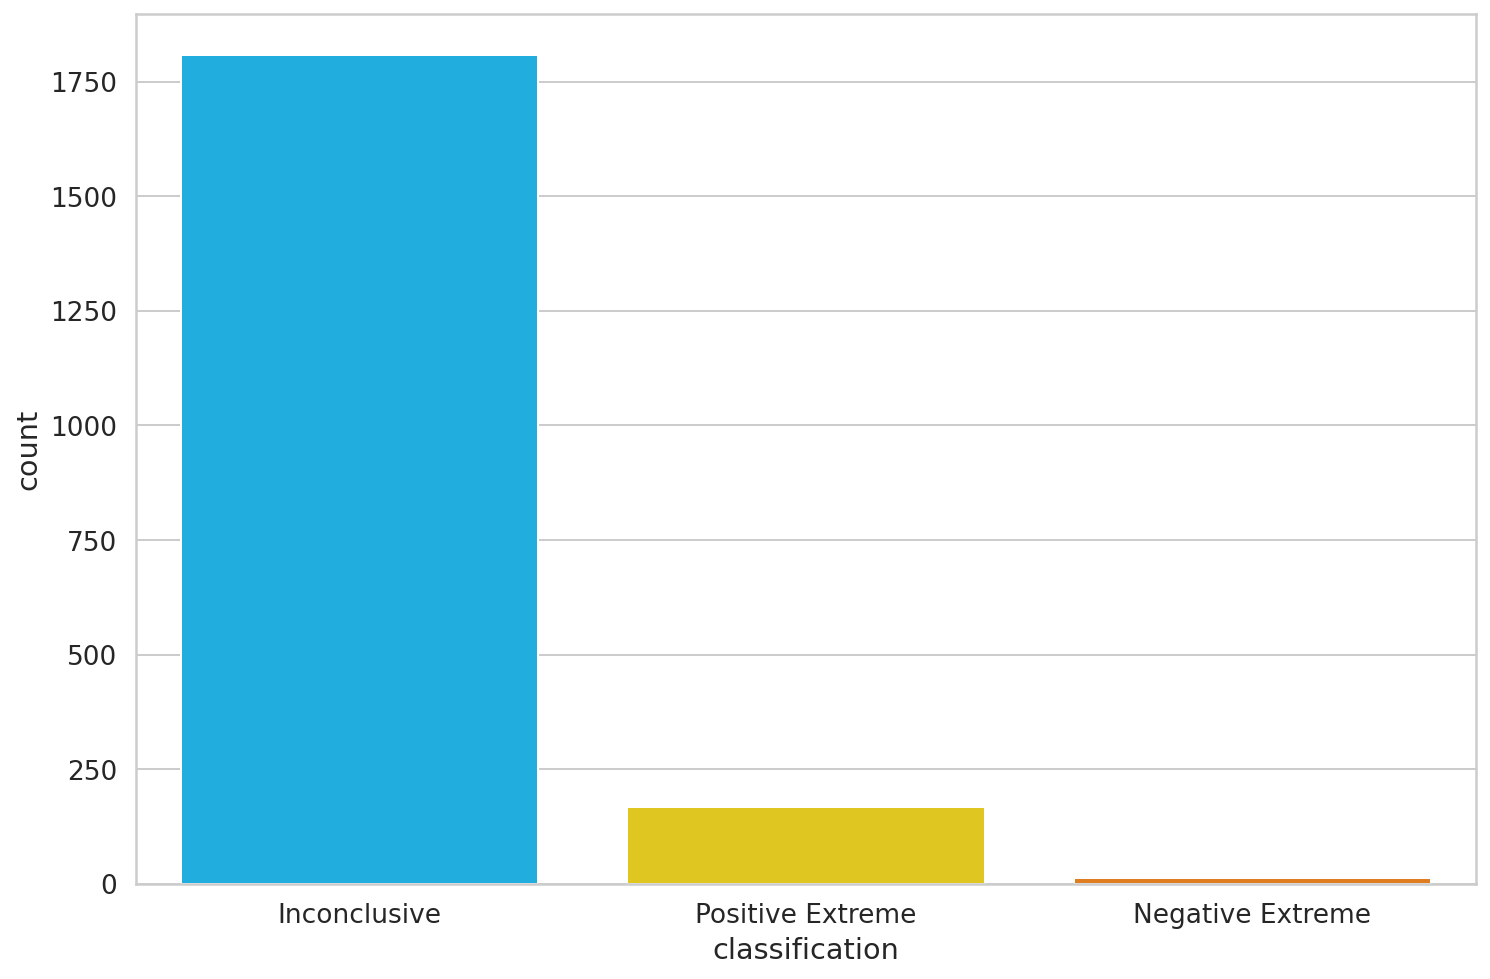

In [33]:
sns.countplot(df.polarity)
plt.xlabel('classification');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


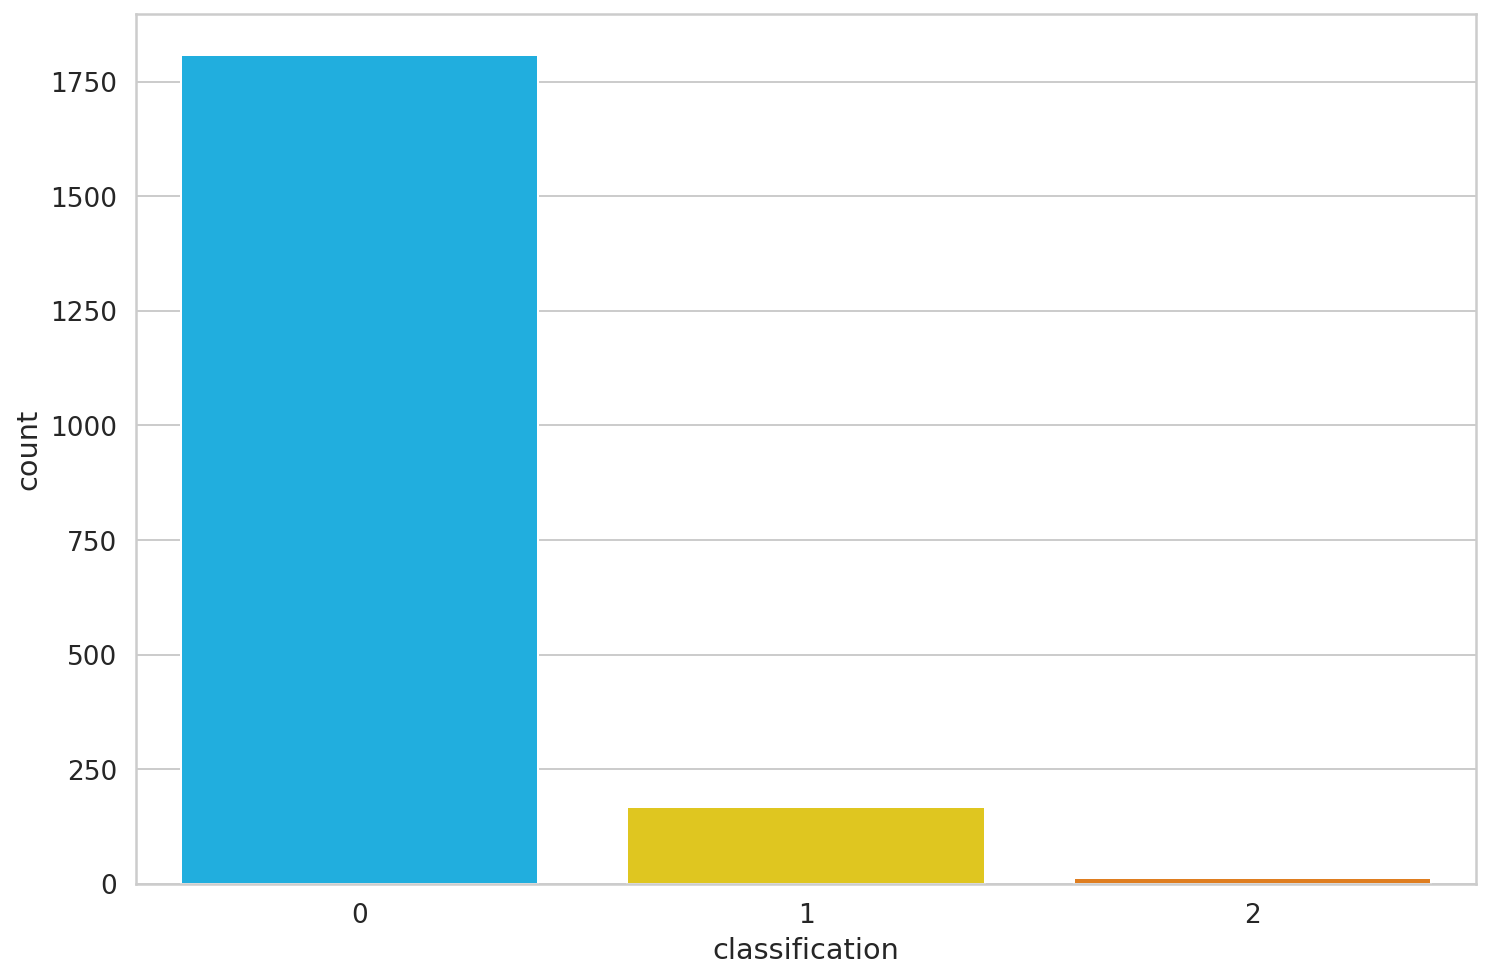

In [34]:
sns.countplot(df.label)
plt.xlabel('classification');

In [35]:
df.head()

,message,polarity,originalClassification,label
0,Reading my kindle2... Love it... Lee childs i...,Inconclusive,4,0
1,"Ok, first assesment of the #kindle2 ...it fuck...",Inconclusive,4,0
2,You'll love your Kindle2. I've had mine for a...,Inconclusive,4,0
3,Fair enough. But i have the Kindle2 and I th...,Positive Extreme,4,1
4,no. it is too big. I'm quite happy with the K...,Positive Extreme,4,1


In [36]:
df = df.drop("polarity",axis=1)
df = df.drop("originalClassification",axis=1)

In [ ]:
"""
def get_split(text):
    l_total = []
    l_parcial = []
    if len(text.split())//450 >0:
      n = len(text.split())//450
    else: 
      n = 1
    for w in range(n):
      if w == 0:
        l_parcial = text.split()[:500]
        l_total.append(" ".join(l_parcial))
      else:
        l_parcial = text.split()[w*450:w*450 + 500]
        l_total.append(" ".join(l_parcial))
    return l_total"""

'\ndef get_split(text):\n    l_total = []\n    l_parcial = []\n    if len(text.split())//450 >0:\n      n = len(text.split())//450\n    else: \n      n = 1\n    for w in range(n):\n      if w == 0:\n        l_parcial = text.split()[:500]\n        l_total.append(" ".join(l_parcial))\n      else:\n        l_parcial = text.split()[w*450:w*450 + 500]\n        l_total.append(" ".join(l_parcial))\n    return l_total'

In [ ]:
#df['message_split'] = df['message'].apply(get_split)

In [ ]:
#df['message_split']

In [ ]:
"""def data_augumentation(df, df_name):
    """
    Create a new dataframe from the original one because now one text may contain multiple subtexts of length 200. 
    Text correspond to subtexts from original text, while index correspond to its index of original set.
    """
    text_l = []
    label_l = []
    index_l = []
    for idx,row in df.iterrows():
      for l in row['message_split']:
        text_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
    new_df = pd.DataFrame({'message':text_l, 'label':label_l, 'index':index_l})
    print("The " + df_name +" set now has " + str(len(new_df)) + ' subtexts extracted from ' + str(len(df)) + ' messsage.')
    return new_df
"""


IndentationError: ignored

In [ ]:
#df = data_augumentation(df, df_name = 'all')

In [ ]:
#train_df = data_augumentation(df_train, df_name = 'training')
#val_df = data_augumentation(df_val, df_name  = 'validation')
#test_df = data_augumentation(df_test, df_name = 'testing')

In [ ]:
#df['message_len'] = df['message'].astype(str).apply(len)
#calculating the length of headlines and descriptions
#df['message_len'] = df['message'].apply(lambda x: len(str(x).split()))

In [ ]:
#df["message_len"].describe().apply(lambda x: format(x, 'f'))

In [ ]:
"""sns.displot( df , x= "message_len" );
plt.xlim([0, 50]);
"""

'sns.displot( df , x= "message_len" );\nplt.xlim([0, 50]);\n'

In [37]:

# Class count
count_class_0, count_class_1,count_class_2 = df.label.value_counts()

# Divide by class
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]
df_class_2 = df[df['label'] == 2]
#df_class_3 = df[df['label'] == 3]
#df_class_4 = df[df['label'] == 4]

Random under-sampling:
2    168
1    168
0    168
Name: label, dtype: int64


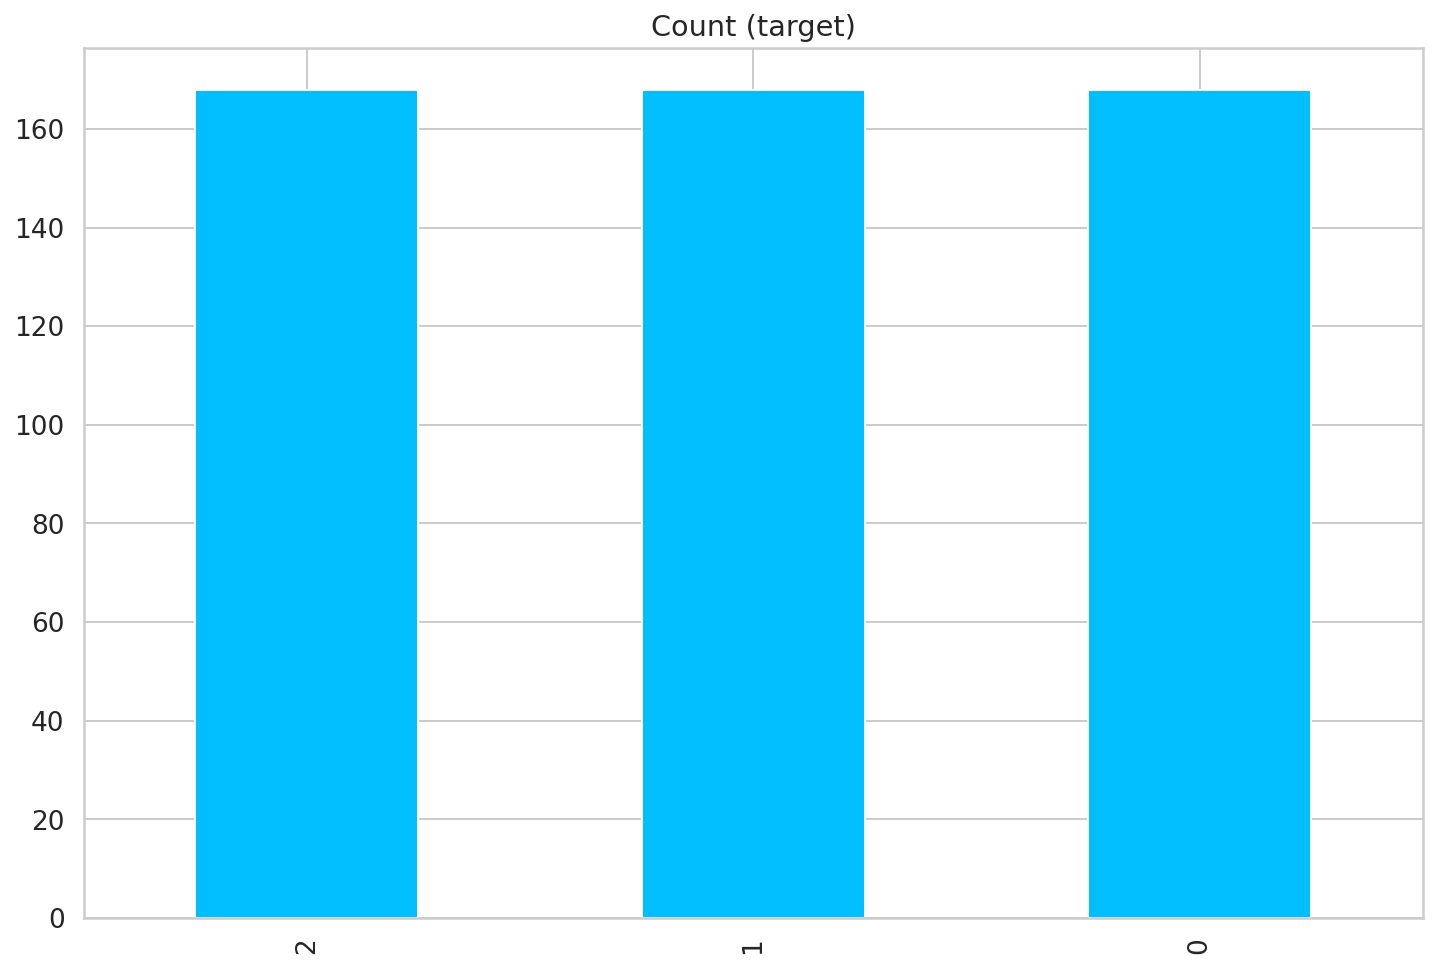

In [39]:
df_class_0_under = df_class_0.sample(n=count_class_1,random_state = 12)
df_class_2_over = df_class_2.sample(count_class_1,random_state = 12,replace=True)
#df_class_2_under = df_class_2.sample(count_class_4,random_state = 12)
#df_class_3_under = df_class_3.sample(count_class_4,random_state = 12)
df_test_under = pd.concat([df_class_0_under, df_class_2_over, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.label.value_counts())


df_test_under.label.value_counts().plot(kind='bar', title='Count (target)');

In [40]:
df_test_under.head()

,message,label
1385,Pissed at Time Warner for causin me to have sl...,0
1936,jquery Selectors http//codylindley.com/jquerys...,0
1853,Watching Night at the Museum - giggling.,0
275,SOOO DISSAPOiNTED THEY SENT DANNY GOKEY HOME.....,0
1933,"I'm ready to drop the pretenses, I am forever ...",0


In [41]:
df_test_under = df_test_under.sample(frac=1).reset_index(drop=True)

In [42]:
df_test_under.head(10)

,message,label
0,Ahh...got rid of stupid time warner today &amp...,2
1,ugh. the amount of times these stupid insects ...,2
2,http//twitpic.com/62shi - Yay! Happy place! P...,1
3,"all about Ajax,jquery ,css ,JavaScript and mor...",0
4,hey no offense but malcolm gladwell is a pret...,2
5,NVIDIA Names Stanford's Bill Dally Chief Scien...,0
6,Ahh...got rid of stupid time warner today &amp...,1
7,Recovering from surgery..wishing was here (,0
8,"It's a bank holiday, yet I'm only out of work ...",1
9,Man I kinda dislike Apple right now. Case in p...,1


In [43]:
df_train, df_test = train_test_split(
  df_test_under,
  test_size=0.2,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [44]:
df_train.shape, df_val.shape, df_test.shape

((403, 2), (50, 2), (51, 2))

In [45]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [46]:
#PRE_TRAINED_MODEL_NAME = "bert-base-multilingual-uncased"
PRE_TRAINED_MODEL_NAME = "bert-base-cased"

In [47]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [48]:
token_lens = []
for txt in df.message:
  tokens = tokenizer.encode(txt, truncation=True)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


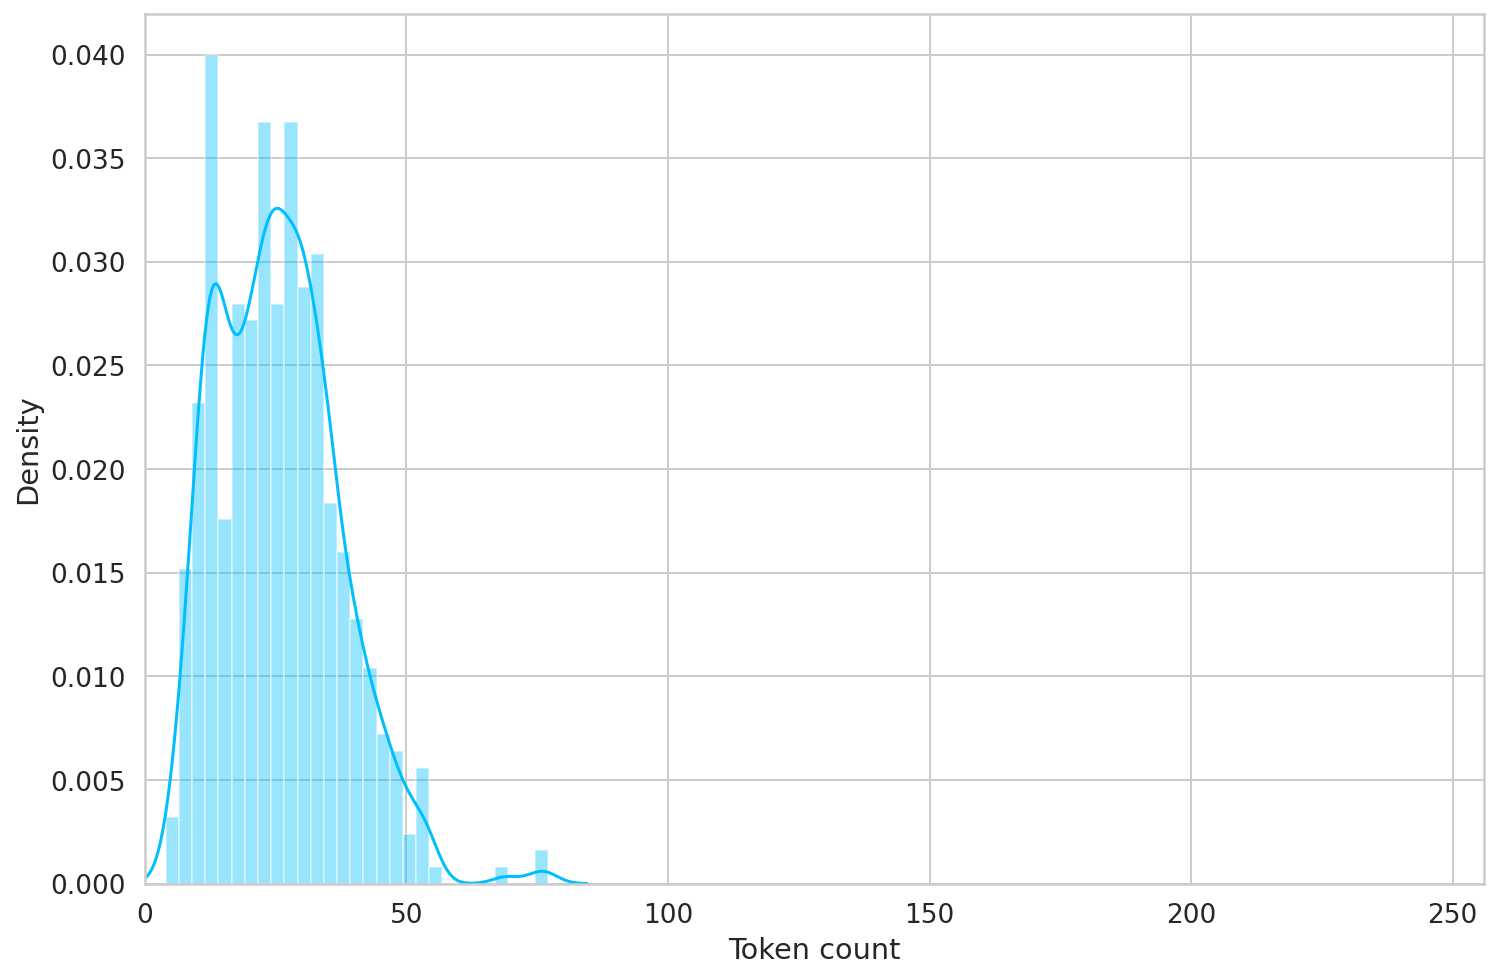

In [49]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [50]:
MAX_LEN = 55

In [51]:
class ExtremsSentiDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):

    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
      
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [52]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ExtremsSentiDataset(
    reviews=df.message.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True
  )

In [53]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)



In [54]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [55]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [57]:

model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 55])
torch.Size([16, 55])


In [59]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

In [60]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 55])
torch.Size([16, 55])


In [61]:

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

In [62]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4340, 0.3863, 0.1798],
        [0.3792, 0.4505, 0.1703],
        [0.3342, 0.3363, 0.3295],
        [0.3393, 0.2768, 0.3839],
        [0.3548, 0.4328, 0.2124],
        [0.6770, 0.2081, 0.1149],
        [0.4241, 0.4139, 0.1620],
        [0.5783, 0.3519, 0.0698],
        [0.4482, 0.3860, 0.1658],
        [0.5330, 0.3142, 0.1527],
        [0.3619, 0.3095, 0.3286],
        [0.4749, 0.2017, 0.3234],
        [0.4814, 0.3386, 0.1800],
        [0.5159, 0.2989, 0.1852],
        [0.3997, 0.3956, 0.2047],
        [0.3392, 0.4698, 0.1910]], grad_fn=<SoftmaxBackward>)

In [63]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [64]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [65]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [66]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [67]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [68]:


import torch

# Check GPU memory using nvidia-smi
#del train_data_loader
#del val_data_loader
#del test_data_loader
torch.cuda.empty_cache()
# Check GPU memory again

In [69]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

In [70]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 6)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/6
------
Train loss 0.9122271033433768 accuracy 0.5459057071960298
Val   loss 0.6098166406154633 accuracy 0.62

Epoch 2/6
------
Train loss 0.5582979906063813 accuracy 0.7890818858560794
Val   loss 0.5445738285779953 accuracy 0.8

Epoch 3/6
------
Train loss 0.27332712672292614 accuracy 0.9081885856079405
Val   loss 0.30442279018461704 accuracy 0.86

Epoch 4/6
------
Train loss 0.21172755942321742 accuracy 0.9230769230769231
Val   loss 0.16783191077411175 accuracy 0.94

Epoch 5/6
------
Train loss 0.22160672023892403 accuracy 0.9230769230769231
Val   loss 0.4038589894771576 accuracy 0.86

Epoch 6/6
------
Train loss 0.2075033916447025 accuracy 0.9230769230769231
Val   loss 0.3423644956201315 accuracy 0.88

CPU times: user 20min 41s, sys: 3min 13s, total: 23min 55s
Wall time: 23min 52s


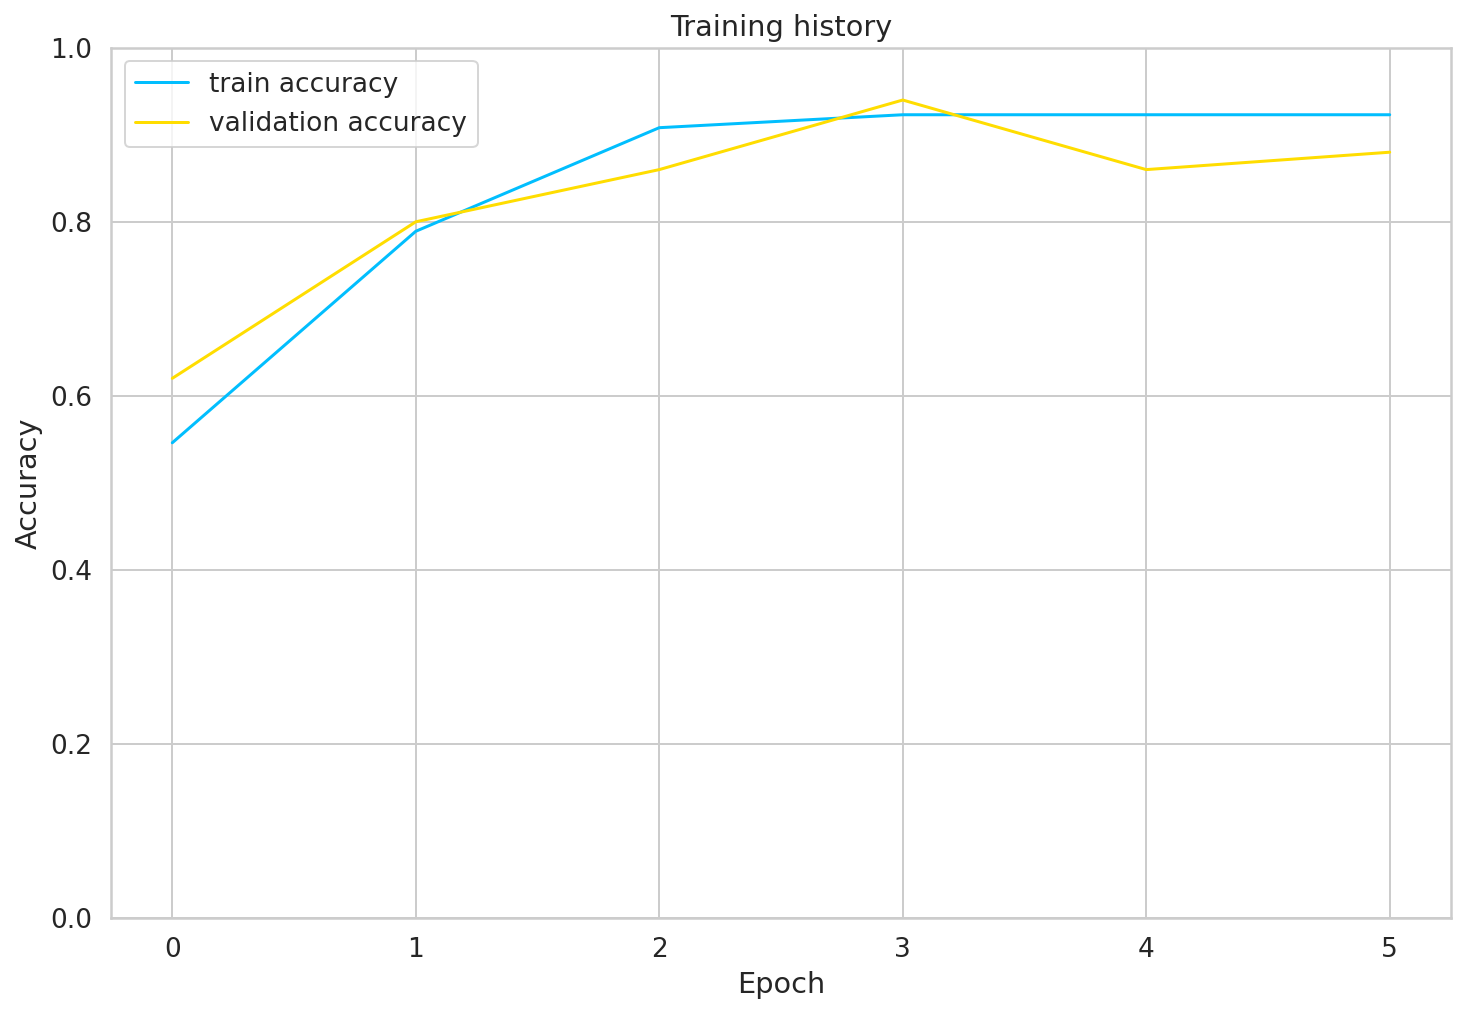

In [71]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [72]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()


0.8823529411764706

In [73]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [74]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [75]:
print(classification_report(y_test, y_pred, target_names=class_names))

                  precision    recall  f1-score   support

    Inconclusive       1.00      0.88      0.93        24
Positive Extreme       0.80      0.80      0.80        15
Negative Extreme       0.80      1.00      0.89        12

        accuracy                           0.88        51
       macro avg       0.87      0.89      0.87        51
    weighted avg       0.89      0.88      0.88        51



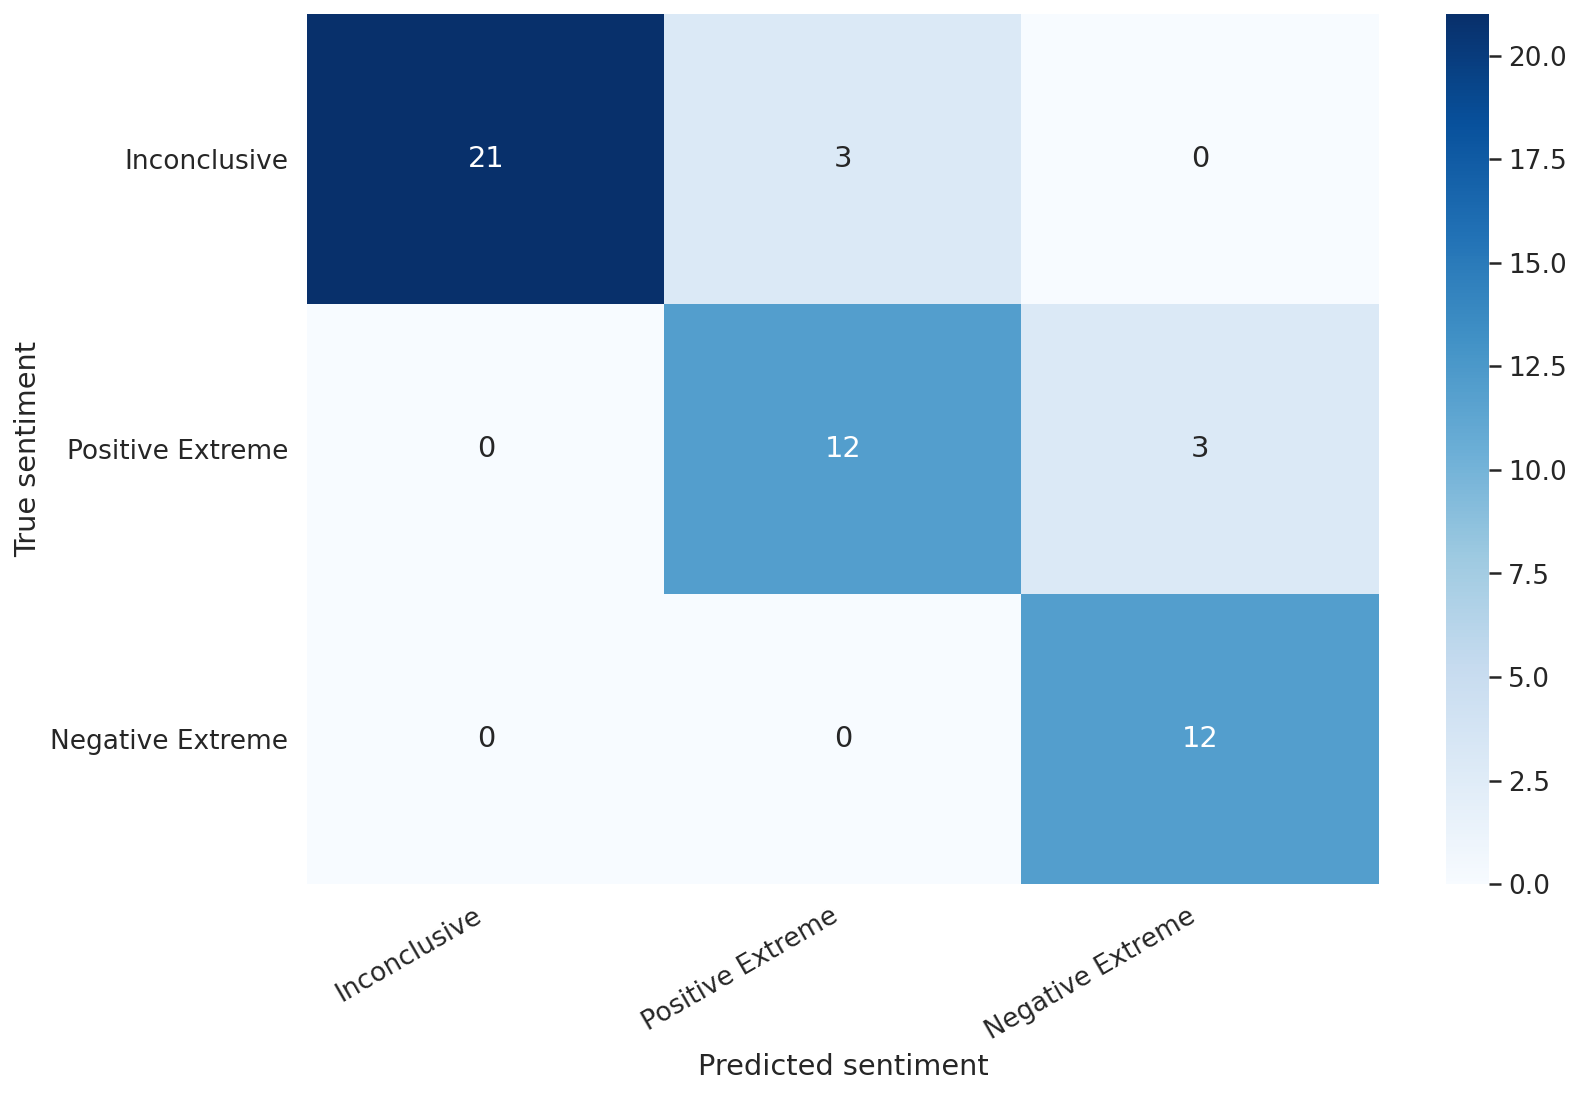

In [76]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)